# Binary classification with Keras neural network running on GPU

Original notebook: https://www.kaggle.com/kosovanolexandr/keras-nn-x-ray-predict-pneumonia-86-54  
Dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

### Our Goal

The goal of this notebook is to demonstrate how easy it is to use GPU on an Openshift Cluster with Open Data Hub components running on top of it.  
Jupyter Notebook has been deployed by the Open Data Hub operator and this notebook image was build thanks to the operator with all the dependencies needed to use the GPU. Especially we are working with tensorflow-gpu version 2.7.0 and Cuda version 11.4.  
We will demonstrate the GPU usage with this neural network. We will train a neural network with xrays of chests in order to predict if a patient suffers from a pneumonia.

You can run this notebook cell by cell and see the ressource usage on the following Grafana: https://grafana-route-grafana.apps.sno-nvidia-p6.redhat.hpecic.net/?orgId=1

### Imports

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
import tensorflow as tf

import os
import numpy as np
import pandas as np

import matplotlib.pyplot as plt
%matplotlib inline

### Check that GPU is enable by default

We can see that a device named */physical_device:GPU:0* has been discovered thanks to the dependencies installed with this notebook image. The type of this device is *GPU*

In [2]:
print('List of available GPUs: ', tf.config.list_physical_devices('GPU'))
print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

List of available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs Available:  1


### Verify our directories structure

In [3]:
print(os.listdir("/opt/app-root/src/data/chest_xray"))

print(os.listdir("/opt/app-root/src/data/chest_xray/test"))

print(os.listdir("/opt/app-root/src/data/chest_xray/train/"))

['.DS_Store', 'test', 'train']
['.DS_Store', 'PNEUMONIA', 'NORMAL']
['.DS_Store', 'PNEUMONIA', 'NORMAL']


### Check an image in the "NORMAL" training set

Let's display a random image from the normal training set i.e tagged as a patient without any pneumonia

NORMAL


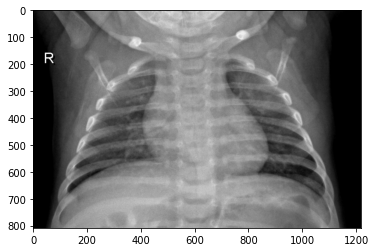

In [4]:
img_name = 'NORMAL2-IM-0588-0001.jpeg'
img_normal = load_img('/opt/app-root/src/data/chest_xray/train/NORMAL/' + img_name)

print('NORMAL')
plt.imshow(img_normal)
plt.show()

### Check an image in the PNEUMONIA training set

Let's display a random image from the pneumonia training set i.e tagged as a patient who suffers from a pneumonia

PNEUMONIA


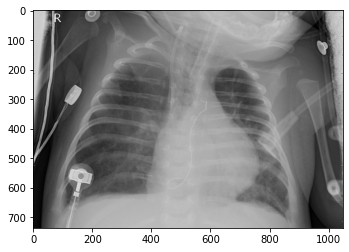

In [5]:
img_name = 'person63_bacteria_306.jpeg'
img_pneumonia = load_img('/opt/app-root/src/data/chest_xray/train/PNEUMONIA/' + img_name)

print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()

### Initialize variables

We are defining few variables

In [6]:
# dimensions of our images.
img_width, img_height = 150, 150

In [7]:
train_data_dir = '/opt/app-root/src/data/chest_xray/train'
test_data_dir = '/opt/app-root/src/data/chest_xray/test'

nb_train_samples = 5232
epochs = 20 # Number of time we procces the entire dataset
batch_size = 16 # Number of images feeded at a time

In [8]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Create Sequential model

We define the Keras model and add some layers in order to create our neural network

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

2022-11-02 16:31:26.691929: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 16:31:29.491193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15563 MB memory:  -> device: 0, name: Tesla P6, pci bus id: 0000:5c:00.0, compute capability: 6.1


### Check information about the model

In [10]:
model.layers

In [11]:
model.input

<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'conv2d_input')>

In [12]:
model.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'activation_4')>

### Compile the model

We define the loss, optimizer and metrics that will be used as improvement goals for the neural network

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Upload images from the different sets

In [14]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [15]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [16]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 5232 images belonging to 2 classes.


In [17]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 624 images belonging to 2 classes.


### Fit the model

#### Choose between CPU and GPU

In [18]:
# GPU
device_path="/gpu:0"
# CPU
# device_path="/cpu:0"

Before training the model, you can open the Grafana instance and observe the different dashboards about the resource consumption.  
Here is the [GPU usage dashboard](https://grafana-route-grafana.apps.sno-nvidia-p6.redhat.hpecic.net/d/51c4ef955d49b81689012770a4b1791ba80e9c7a/nvidia-dcgm-exporter-dashboard?orgId=1)  
Here is the [CPU usage dashboard](https://grafana-route-grafana.apps.sno-nvidia-p6.redhat.hpecic.net/d/4ccbbd05fa2622168c09e3b8b92194d2f5825d95/kubernetes-compute-resources-pod?orgId=1&refresh=10s)  
On both dashboard you can check the *Utilization* graph.  
Note that as some other graph values are calculated on a 5m range, you need to wait a bit after started trainning the model before the peak appears.

In [19]:
with tf.device(device_path):
    model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs)

Epoch 1/20


2022-11-02 16:31:32.045901: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8600
2022-11-02 16:31:32.733963: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


327/327 [==============================] - 65s 191ms/step - loss: 0.4368 - accuracy: 0.7953
Epoch 2/20
327/327 [==============================] - 63s 193ms/step - loss: 0.3268 - accuracy: 0.8739
Epoch 3/20
327/327 [==============================] - 62s 190ms/step - loss: 0.2735 - accuracy: 0.8867
Epoch 4/20
327/327 [==============================] - 63s 193ms/step - loss: 0.2486 - accuracy: 0.9127
Epoch 5/20
327/327 [==============================] - 62s 190ms/step - loss: 0.2363 - accuracy: 0.9190
Epoch 6/20
327/327 [==============================] - 63s 192ms/step - loss: 0.2316 - accuracy: 0.9199
Epoch 7/20
327/327 [==============================] - 62s 189ms/step - loss: 0.2319 - accuracy: 0.9209
Epoch 8/20
327/327 [==============================] - 62s 191ms/step - loss: 0.2064 - accuracy: 0.9278
Epoch 9/20
327/327 [==============================] - 63s 192ms/step - loss: 0.2110 - accuracy: 0.9335
Epoch 10/20
327/327 [==============================] - 64s 195ms/step - loss: 0.2144

### Evaluate the model

In [20]:
# evaluate the model
scores = model.evaluate(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

39/39 [==============================] - 5s 113ms/step - loss: 0.3744 - accuracy: 0.8798

accuracy: 87.98%
